<a href="https://colab.research.google.com/github/plaban1981/Hugging_Face_transformers_topics/blob/main/Natural_Language_Processing_using_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Agenda

* Introduction to the transformer
* Understanding the encoder of the transformer
* Understanding the decoder of the transformer
* Putting the encoder and decoder together
* Training the transformer

## Introduction to the transformer
RNN and LSTM networks are widely used in sequential tasks such as next word
prediction, machine translation, text generation, and more. However one of the **major
challenges with the recurrent model is capturing the long-term dependency**

Transformers overcome this limitation using **Self Attention Mechanishm**

Consider the following two sentences:
* Sentence A: He got bit by Python.
* Sentence B: Python is my favorite programming language.


* Self Attention Mechanism : Here model relates each word with all other words in the sentences to understand the context of the word better

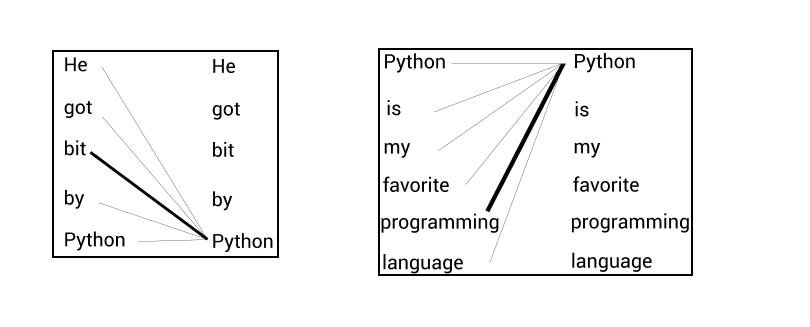

* Here python in sentence 1 referes to a snake while python in sentence 2 refers to a programming language

* Now,if we get embeddings for the word 'Python' in the preceding two sentences using an **embedding model such as word2vec**, the embedding of the word **'Python'** would be the **same** in both sentences, and so this renders the meaning of the word 'Python' the same in
both sentences.

* This is because word2vec is the context-free model, so it will ignore the context and always give the same embedding for the word 'Python' irrespective of the context.

* Transformers, on the other hand, is a context-based model. 
* It will understand the context and then
generate the embedding for the word based on the context. 
* So, for the preceding two
sentences, it will give different embeddings for the word **'Python'** based on the context.

## Fine Tune Transformers Model like BERT on Custom Dataset.

In [ ]:
!pip install transformers -U

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.9 MB 15.7 MB/s 
     |████████████████████████████████| 163 kB 61.4 MB/s 
     |████████████████████████████████| 6.6 MB 58.5 MB/s 


## Dataset
https://www.kaggle.com/competitions/jigsaw-toxic-comment-classification-challenge/data

## Download dataset from kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"plabannayak","key":"f1f19a1783935d871fc0049a716ef3a8"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c jigsaw-toxic-comment-classification-challenge

 85% 45.0M/52.6M [00:01<00:00, 38.1MB/s]
100% 52.6M/52.6M [00:01<00:00, 50.4MB/s]


In [ ]:
!mkdir Data

In [ ]:
!unzip /content/jigsaw-toxic-comment-classification-challenge.zip 

Archive:  /content/jigsaw-toxic-comment-classification-challenge.zip
  inflating: sample_submission.csv.zip  
  inflating: test.csv.zip            
  inflating: test_labels.csv.zip     
  inflating: train.csv.zip           


In [ ]:
!unzip "/content/train.csv.zip" -d "/content/Data"

Archive:  /content/train.csv.zip
  inflating: /content/Data/train.csv  


In [ ]:
!unzip "/content/test.csv.zip" -d "/content/Data"

Archive:  /content/test.csv.zip
  inflating: /content/Data/test.csv  


In [ ]:
!unzip "/content/test_labels.csv.zip" -d "/content/Data"

Archive:  /content/test_labels.csv.zip
  inflating: /content/Data/test_labels.csv  


In [ ]:
import pandas as pd
data = pd.read_csv("/content/Data/train.csv")
data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [ ]:
data.shape

(159571, 8)

In [ ]:
data['toxic'].value_counts()

0    144277
1     15294
Name: toxic, dtype: int64

## Import necessary libraries

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import torch
#libraries required to finetune BERT
from transformers import TrainingArguments, Trainer
from transformers import BertTokenizer, BertForSequenceClassification

In [ ]:
df = data.copy()

In [ ]:
df['label'] =  list(zip(df.toxic.tolist(), df.severe_toxic.tolist(), df.obscene.tolist(), df.threat.tolist(),  df.insult.tolist(), df.identity_hate.tolist()))

In [ ]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,label
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,"(0, 0, 0, 0, 0, 0)"
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,"(0, 0, 0, 0, 0, 0)"
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,"(0, 0, 0, 0, 0, 0)"
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,"(0, 0, 0, 0, 0, 0)"
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,"(0, 0, 0, 0, 0, 0)"


In [ ]:
df[df['toxic'] ==1].head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,label
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0,"(1, 1, 1, 0, 1, 0)"
12,0005c987bdfc9d4b,Hey... what is it..\n@ | talk .\nWhat is it......,1,0,0,0,0,0,"(1, 0, 0, 0, 0, 0)"
16,0007e25b2121310b,"Bye! \n\nDon't look, come or think of comming ...",1,0,0,0,0,0,"(1, 0, 0, 0, 0, 0)"
42,001810bf8c45bf5f,You are gay or antisemmitian? \n\nArchangel WH...,1,0,1,0,1,1,"(1, 0, 1, 0, 1, 1)"
43,00190820581d90ce,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1,0,1,0,1,0,"(1, 0, 1, 0, 1, 0)"


## Load Model and Tokenizer

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased',num_labels=2)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
#model = model.to('cuda')

In [ ]:
sample_data = ["I am eating","I am playing "]
tokenizer(sample_data, padding=True, truncation=True, max_length=512)

{'input_ids': [[101, 1045, 2572, 5983, 102], [101, 1045, 2572, 2652, 102]], 'token_type_ids': [[0, 0, 0, 0, 0], [0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1], [1, 1, 1, 1, 1]]}

In [ ]:
df.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
label            0
dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
 8   label          159571 non-null  object
dtypes: int64(6), object(3)
memory usage: 11.0+ MB


In [ ]:
label_dict = df.label.value_counts().to_dict()

In [ ]:
drop_label = [k for k,v in label_dict.items() if v < 2]

In [ ]:
drop_label

[(1, 1, 0, 1, 1, 0), (1, 1, 0, 1, 0, 1)]

In [ ]:
df_new = df[~df['label'].isin(drop_label)]

In [ ]:
df_new.label.nunique()

39

## Train Test Split

In [ ]:
data = data[['comment_text','toxic']]
data = data[0:1000]
data.head()

,comment_text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [ ]:
X = list(data["comment_text"])
y = list(data["toxic"])
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2,stratify=y)
X_train_tokenized = tokenizer(X_train, padding=True, truncation=True, max_length=512)
X_val_tokenized = tokenizer(X_val, padding=True, truncation=True, max_length=512)

In [ ]:
X_train_tokenized.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [ ]:
len(X_train),len(X_val)

(800, 200)

## To fine tune custom dataset we need to convert the tokenized output into Dataset format

* we need to implement the below methods 
    - __init__ method
    - __getitem__ method
    - __len__ method

In [ ]:
# Create torch dataset
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])

In [ ]:
train_dataset = Dataset(X_train_tokenized, y_train)
val_dataset = Dataset(X_val_tokenized, y_val)

In [ ]:
train_dataset[5]

{'input_ids': tensor([  101,  1000, 16948,  1024,  4790,  2005,  3972, 20624,  2239,  1013,
         18178,  5063,  6672, 27741,  2115,  2695,  2012,  1996,  2682, 21358,
          2094,  2006,  1037,  2047,  7761,  2396,  8572,  2015,  2033,  1012,
          2023,  2001,  1996,  2544,  2012,  1996,  2051,  1010,  2008,  2017,
          2241,  2115,  2695,  2006,  1012,  2017,  6866,  1024,  1000,  1000,
          1045,  2074,  3191,  1996,  3720,  1010,  1998,  2000,  2022,  3243,
          7481,  1010,  2514,  2008,  2009,  2515, 13225, 16948,  1005,  1055,
         11594,  1012,  1012,  1012,  2009,  2003,  2128,  6632,  6321, 23184,
          1012,  1012,  1012,  2144,  1045,  2903,  1996,  2025,  8010,  1997,
          1996,  3720,  2003,  8510,  1012,  1012,  1012,  2009,  2085,  2038,
          2340,  2981,  4216,  1012,  1998,  2000, 25416, 10421,  1996,  6685,
         13686,  2011,  6159,  1010,  2009,  2003,  4340,  2011,  1996, 10852,
          1054, 21030,  3120,  2008,  1

* attention mask 0 indicates actual word
* attention mask 1 indicates padding

In [ ]:
def compute_metrics(p):
    print(type(p))
    pred, labels = p
    pred = np.argmax(pred, axis=1)

    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred)
    precision = precision_score(y_true=labels, y_pred=pred)
    f1 = f1_score(y_true=labels, y_pred=pred)

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

## Use this code to see memory usage

In [ ]:
!pip install GPUtil

from GPUtil import showUtilization as gpu_usage
gpu_usage()   

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7411 sha256=799b851d83635e1633e73ac4ee012f2ee8b98cbce04e6242d6f414647a72525b
  Stored in directory: /root/.cache/pip/wheels/6e/f8/83/534c52482d6da64622ddbf72cd93c35d2ef2881b78fd08ff0c
Successfully built GPUtil
| ID | GPU | MEM |
------------------
|  0 |  0% |  0% |


## Use this code to clear your memory:

In [ ]:
import torch
from GPUtil import showUtilization as gpu_usage
from numba import cuda

def free_gpu_cache():
    print("Initial GPU Usage")
    gpu_usage()                             

    torch.cuda.empty_cache()

    cuda.select_device(0)
    cuda.close()
    cuda.select_device(0)

    print("GPU Usage after emptying the cache")
    gpu_usage()

 

## You can also use this code to clear your memory

In [ ]:
# Define Trainer
args = TrainingArguments(
    output_dir="output",
    num_train_epochs=1,
    per_device_train_batch_size=8

)
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

In [ ]:
training_args = TrainingArguments(
    output_dir='./res',          # output directory
    evaluation_strategy="steps",
    num_train_epochs=1,              # total number of training epochs
    per_device_train_batch_size=32,  # batch size per device during training
    per_device_eval_batch_size=32,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs4',            # directory for storing logs
    logging_steps=10,
    load_best_model_at_end=True,
    report_to =None,
)

using `logging_steps` to initialize `eval_steps` to 10
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args ,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

In [ ]:
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 800
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 100


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=100, training_loss=0.2832786560058594, metrics={'train_runtime': 2360.822, 'train_samples_per_second': 0.339, 'train_steps_per_second': 0.042, 'total_flos': 210488844288000.0, 'train_loss': 0.2832786560058594, 'epoch': 1.0})

## evaluate the model trained

In [ ]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 200
  Batch size = 8


<class 'transformers.trainer_utils.EvalPrediction'>


{'eval_loss': 0.12016664445400238,
 'eval_accuracy': 0.945,
 'eval_precision': 0.75,
 'eval_recall': 0.7142857142857143,
 'eval_f1': 0.7317073170731706,
 'eval_runtime': 214.1354,
 'eval_samples_per_second': 0.934,
 'eval_steps_per_second': 0.117,
 'epoch': 1.0}

In [ ]:
np.set_printoptions(suppress=True)

## Make Inference based on the Trained Model

In [ ]:
text = "That was so gross"
inputs = tokenizer(text,padding = True, truncation = True, return_tensors='pt')
outputs = model(**inputs)
print(outputs)
predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
print(predictions)
predictions = predictions.cpu().detach().numpy()
predictions

## Save the Model

In [ ]:
trainer.save_model('CustomModel')

## Load the saved Model and make predictions

In [ ]:
saved_model = BertForSequenceClassification.from_pretrained("CustomModel")

In [ ]:
#saved_model.to('cuda')

## Make Predictions

In [ ]:
text = "That was good point"
inputs = tokenizer(text,padding = True, truncation = True, return_tensors='pt')
#inputs = tokenizer(text,padding = True, truncation = True, return_tensors='pt').to('cuda')
outputs = model_2(**inputs)
predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
predictions = predictions.cpu().detach().numpy()
predictions